In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
import torchvision.datasets as D
import torch.nn.functional as F
import numpy as np
import pickle
from matplotlib import pyplot as plt
import sys
sys.path.append("..")
from utils.utils import MyDataset, show_image, visualise_output, visualise_output_reward
from networks.autoencoder import FireAutoencoder
from networks.autoencoder_reward import FireAutoencoder_reward
from sklearn.decomposition import PCA
import matplotlib
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D  # Import the 3D plotting toolkit

In [2]:
latent_dims = 64
capacity = latent_dims//2
use_gpu =  True
input_size = 20
sigmoid = False
variational_beta = 1

In [3]:
file = open(f"../../data/complete_random/homo_2/Sub20x20_full_grid.pkl", 'rb')
data = pickle.load(file)

In [4]:
dataset = MyDataset(root='../../data/complete_random/hetero_1/Sub20x20_full_grid.pkl',
                             tform=lambda x: torch.from_numpy(x, dtype=torch.float))

In [139]:
class VAE(nn.Module):
    def __init__(self, capacity, input_size, latent_dims):
        super(VAE, self).__init__()
        self.latent_dims = latent_dims
        self.c = capacity
        kernel_size = 4
        stride = 2
        padding = 1
        self.dim_1 = int((input_size - kernel_size + 2*padding)/2 + 1)
        self.dim_2 = int((self.dim_1 - kernel_size + 2*padding)/2 + 1)
        
        # Encoder layers:
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=self.c, kernel_size=kernel_size, stride=stride, padding=padding) # (64, 10, 10)
        self.conv2 = nn.Conv2d(in_channels=self.c, out_channels=self.c*2, kernel_size=kernel_size, stride=stride, padding=padding) # (128, 5, 5)
        self.fc_mu = nn.Linear(in_features=latent_dims*(self.dim_2**2), out_features = latent_dims)
        self.fc_logvar = nn.Linear(in_features=latent_dims*(self.dim_2**2), out_features = latent_dims)
        
        # Decoder layers:
        self.fc = nn.Linear(in_features=latent_dims, out_features=latent_dims*(self.dim_2**2))
        self.conv1_ = nn.ConvTranspose2d(in_channels=self.c*2, out_channels=self.c, kernel_size=kernel_size, stride=stride, padding=padding)
        self.conv2_ = nn.ConvTranspose2d(in_channels=self.c, out_channels=1, kernel_size=kernel_size, stride=stride, padding=padding)

        # Inicialización de parámetros:
        nn.init.kaiming_uniform_(self.conv1.weight, mode='fan_in', nonlinearity='relu')
        nn.init.kaiming_uniform_(self.conv2.weight, mode='fan_in', nonlinearity='relu')
        nn.init.kaiming_uniform_(self.conv1_.weight, mode='fan_in', nonlinearity='relu')
        nn.init.kaiming_uniform_(self.conv2_.weight, mode='fan_in', nonlinearity='relu')

        # Losses holders:
        self.training_loss = []
        self.validation_loss = []
        self.reconstruction_training_loss = []
        self.reconstruction_validation_loss = []
        self.divergence_training_loss = []
        self.divergence_validation_loss = []
        self.m = 0
        self.n = 0
        self.epoch_loss = 0
        self.val_epoch_loss = 0
        self.reconstruction_epoch_loss = 0
        self.val_reconstruction_epoch_loss = 0
        self.divergence_epoch_loss = 0
        self.val_divergence_epoch_loss = 0

        self.last_mu = None
        self.last_logvar = None
        
    def encode(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1) # flatten batch of multi-channel feature maps to a batch of feature vectors
        x_mu = self.fc_mu(x)
        x_logvar = self.fc_logvar(x)
        return x_mu, x_logvar

    def decode(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), self.c*2, self.dim_2, self.dim_2) # unflatten batch of feature vectors to a batch of multi-channel feature maps
        x = F.relu(self.conv1_(x))
        x = torch.sigmoid(self.conv2_(x)) # last layer before output is sigmoid, since we are using BCE as reconstruction loss
        return x
    
    def forward(self, x):
        latent_mu, latent_logvar = self.encode(x)
        latent = self.latent_sample(latent_mu, latent_logvar)
        x_recon = self.decode(latent)
        self.last_mu = latent_mu
        self.last_logvar = latent_logvar
        return x_recon
    
    def latent_sample(self, mu, logvar):
        if self.training:
            # the reparameterization trick
            std = logvar.mul(0.5).exp_()
            eps = torch.empty_like(std).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu
    
    def vae_loss(self, recon_x, x, mu, logvar):
        # recon_x is the probability of a multivariate Bernoulli distribution p.
        # -log(p(x)) is then the pixel-wise binary cross-entropy.
        # Averaging or not averaging the binary cross-entropy over all pixels here
        # is a subtle detail with big effect on training, since it changes the weight
        # we need to pick for the other loss term by several orders of magnitude.
        # Not averaging is the direct implementation of the negative log likelihood,
        # but averaging makes the weight of the other loss term independent of the image resolution.
        recon_loss = F.binary_cross_entropy(recon_x.view(-1, 400), x.view(-1, 400), reduction='sum')
        
        # KL-divergence between the prior distribution over latent vectors
        # (the one we are going to sample from when generating new images)
        # and the distribution estimated by the generator for the given image.
        kldivergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return recon_loss, kldivergence, recon_loss + variational_beta * kldivergence

    def loss(self, output, x, r):
        mu, logvar = (self.last_mu, self.last_logvar)
        loss_1, loss_2, loss = self.vae_loss(output, x, mu, logvar)
        self.reconstruction_epoch_loss += loss_1.item()
        self.divergence_epoch_loss += loss_2.item()
        self.epoch_loss += loss.item()
        return loss

    
    def val_loss(self, output, x, r):
        mu, logvar = (self.last_mu, self.last_logvar)
        loss_1, loss_2, loss = self.vae_loss(output, x, mu, logvar)
        self.val_reconstruction_epoch_loss += loss_1.item()
        self.val_divergence_epoch_loss += loss_2.item()
        self.val_epoch_loss += loss.item()
        return loss
        
    def reset_losses(self):
        self.training_loss.append(self.epoch_loss/self.n)
        self.validation_loss.append(self.val_epoch_loss/self.m)
        self.reconstruction_training_loss.append(self.reconstruction_epoch_loss/self.n)
        self.reconstruction_validation_loss.append(self.val_reconstruction_epoch_loss/self.m)
        self.divergence_training_loss.append(self.divergence_epoch_loss/self.n)
        self.divergence_validation_loss.append(self.val_divergence_epoch_loss/self.m)
        self.epoch_loss = 0
        self.val_epoch_loss = 0
        self.reconstruction_epoch_loss = 0
        self.val_reconstruction_epoch_loss = 0
        self.divergence_epoch_loss = 0
        self.val_divergence_epoch_loss = 0
        self.m = 0
        self.n = 0

In [140]:
net = VAE(capacity, input_size, latent_dims)

In [141]:
total_params = sum(p.numel() for p in net.parameters())
print(f"Number of parameters: {total_params}")

Number of parameters: 375617


In [142]:
train_dataset, validation_dataset, test_dataset =torch.utils.data.random_split(dataset, [0.9, 0.05, 0.05])
batch = 16
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch, shuffle=False)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch, shuffle=False)
test_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch, shuffle=False)

In [143]:
optimizer = torch.optim.Adam(net.parameters(), lr = 0.0001)

In [144]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net.to(device)
epochs = 10
training_loss = []
validation_loss = []
for epoch in range(epochs):
    n = 0
    m = 0
    epoch_loss = 0
    val_epoch_loss = 0
    for x, _ in train_loader:
        x = x.to(device)
        output = net(x)
        loss = net.loss(output, x, _)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        net.n += 1
    
    for y, _ in validation_loader:
        y = y.to(device)
        output = net(y)
        val_loss = net.val_loss(output, y, _)
        optimizer.zero_grad()
        val_epoch_loss += val_loss.item()
        net.m+=1
    net.reset_losses()
    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, epochs, loss.item()))
    print('Epoch [{}/{}], Validation Loss: {:.4f}'.format(epoch+1, epochs, val_loss.item()))

Epoch [1/10], Loss: 685.5781
Epoch [1/10], Validation Loss: 1021.7814
Epoch [2/10], Loss: 630.1451
Epoch [2/10], Validation Loss: 953.3658
Epoch [3/10], Loss: 630.1645
Epoch [3/10], Validation Loss: 915.3002
Epoch [4/10], Loss: 599.5290
Epoch [4/10], Validation Loss: 908.4174
Epoch [5/10], Loss: 593.3741
Epoch [5/10], Validation Loss: 894.3952
Epoch [6/10], Loss: 593.9331
Epoch [6/10], Validation Loss: 899.7952
Epoch [7/10], Loss: 595.4787
Epoch [7/10], Validation Loss: 885.1600
Epoch [8/10], Loss: 597.1581
Epoch [8/10], Validation Loss: 881.4828
Epoch [9/10], Loss: 594.9623
Epoch [9/10], Validation Loss: 885.2036
Epoch [10/10], Loss: 589.7548
Epoch [10/10], Validation Loss: 880.2779


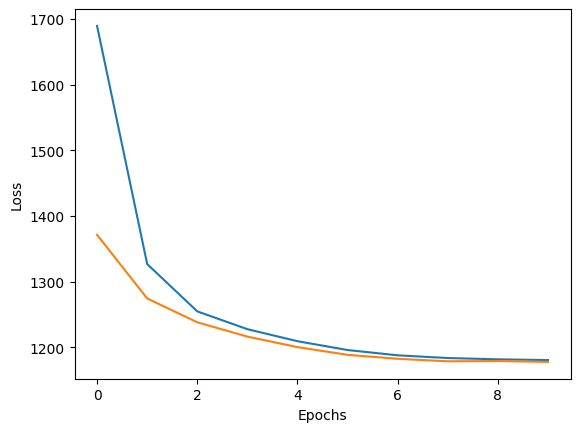

In [145]:
plt.ion()
fig = plt.figure()
plt.plot(net.training_loss, label='training loss'
)
plt.plot(net.validation_loss, label='validation loss'
)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()